Fit CNN in PyTorch
===


## Imports

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import datasets, models, transforms, utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import copy
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import cv2
from skimage import io, transform
from glob import glob


device = 'cuda' if torch.cuda.is_available() else 'cpu'


# number of models
n_ensemble = 2

# size of test and validation set
n_test = 90

# Number of dimensions in the dataset
n_dim = 8

# Batch size for training (change depending on how much memory you have)
batch_size_im = 90
batch_size_ft = 30

# Number of epochs to train for 
num_epochs_im = 15
num_epochs_ft = 15

# where would we use these in pytorch? in keras they are used to create layers for the intermediate model
dropout = 0.5   
n_dense = 256
n_layers = 2

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract_im = True
feature_extract_ft = False

input_size = 224

loglr = -2.2200654426745987
lr_im = 1.2 * 10 ** loglr
lr_ft = 0.00001

IMG_360 = '../sanders_2018/360 Rocks/'
IMG_120 = '../sanders_2018/120 Rocks/'
MDS_360 = '../finetuning_torchvision_data/mds_360.csv'
CHECKPOINTS = 'CNN_checkpoints/'
PATH_IM = CHECKPOINTS + 'state_dict_intermediate_model.pt'
PATH_FT = CHECKPOINTS + 'state_dict_finetuned_model.pt'

## Functions and classes

In [45]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=14, is_inception=False):
    """
    handles the training and validation of a given model. At the end of
    training returns the best performing model. After each epoch, the training and validation
    accuracies are printed
    """
    
    since = time.time()

    val_acc_history = []
    lrs = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = None
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_r2 = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    score = r2_score(labels.detach().numpy(), outputs.detach().numpy())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        lr = optimizer.param_groups[0]["lr"]
                        lrs.append(lr)

                # statistics 
                running_loss += loss.item() * inputs.size(0)
                running_r2 += score.item() * inputs.size(0)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset) 
            epoch_acc = running_r2 / len(dataloaders[phase].dataset) 

            print(f'{phase} Loss: {epoch_loss: .4f} Acc: {epoch_acc: .4f} lr: {lr: .4e}')

            # deep copy the model
            if phase == 'val' and best_acc == None:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and best_acc < epoch_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        
        print() # empty line between epochs

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, lrs


def set_parameter_requires_grad(model, feature_extracting):
    """
    This helper function sets the ``.requires_grad`` attribute of the
    parameters in the model to False when we are feature extracting.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else:
        for param in model.parameters():
            param.requires_grad = True
    return None


class RocksData(datasets.VisionDataset):
    def __init__(self, df, root_dir):
        super(RocksData).__init__()
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
        self.root_dir = root_dir
    def __len__(self): return len(self.df)
    def __getitem__(self, ix):
        img_path = self.root_dir + "/" + self.df.iloc[ix,0]
        img = cv2.imread(img_path)/255.
        label = deepcopy(self.df.iloc[ix,1:].tolist())
        label = torch.tensor(label).float()
        img = self.preprocess_input(img)
        return img, label
    def preprocess_input(self, img):
        img = cv2.resize(img, (224,224))
        img = torch.tensor(img).permute(2,0,1)
        img = self.normalize(img).float()
        return img.to(device)    

    
class PredictionData(datasets.VisionDataset): # TODO: lots of redundant code. integrate this into above RocksData dataset
    def __init__(self, img_paths):
        super(PredictionData).__init__()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
        self.img_paths = img_paths
    def __len__(self): return len(self.img_paths)
    def __getitem__(self, ix):
        img = cv2.imread(self.img_paths[ix])/255.
        img = self.preprocess_input(img)
        return img
    def preprocess_input(self, img):
        img = cv2.resize(img, (224,224))
        img = torch.tensor(img).permute(2,0,1)
        img = self.normalize(img).float()
        return img.to(device) 
    
    
def get_criterion(loss_name):
    """
    Returns the optimizer
    """
    if loss_name == "L1":
        return torch.nn.L1Loss()
    elif loss_name == "L2":
        return torch.nn.MSELoss()
    elif loss_name == "smooth_L1":
        return torch.nn.SmoothL1Loss()
    elif loss_name == "huber":
        return torch.nn.HuberLoss()
    else:
        raise Exception("No valid loss_name entered!")

## Prepare Data

<div class="alert alert-warning" role="alert">Note: Stratified split still to be implemented!</div>

In [52]:
df = pd.read_csv(MDS_360)

train, test = train_test_split(df, test_size=n_test, random_state=0)
train, val = train_test_split(train, test_size=n_test, random_state=0)
train_dataset = RocksData(train.reset_index(drop=True), IMG_360)
val_dataset = RocksData(val.reset_index(drop=True), IMG_360)
test_dataset = RocksData(test.reset_index(drop=True), IMG_360)
pred_dataset = PredictionData(glob(IMG_120+'*.jpg'))

## Define final layers

This is how the final layers look like in Keras:

```
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================

avg_pool (GlobalAveragePooling  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 2D)                                                                                              
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['avg_pool[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['dropout[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256)         1024        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dropout_1 (Dropout)            (None, 256)          0           ['batch_normalization[0][0]']    
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dropout_1[0][0]']              
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256)         1024        ['dense_1[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 dropout_2 (Dropout)            (None, 256)          0           ['batch_normalization_1[0][0]']  
                                                                                                  
 dense_2 (Dense)                (None, 8)            2056        ['dropout_2[0][0]']       
```

In [4]:
def get_output_layers(dropout, num_ftrs, n_dim, n_layers):
    """
    Returns the output layers.
    """
   
    output = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_ftrs, n_dense), # dense in keras
            nn.ReLU(inplace=True), # dense
            nn.BatchNorm1d(n_dense),
            nn.Dropout(p=dropout),
            nn.Linear(n_dense, n_dense), # dense
            nn.ReLU(inplace=True), # dense
            nn.BatchNorm1d(n_dense),
            nn.Dropout(p=dropout),
            nn.Linear(n_dense, n_dim) # dense
        )
    
    return output

## Train finetuned model only

## Train ensemble

Epoch 1/15
----------
train Loss:  6.5052 Acc: -0.0179 lr:  7.2296e-03
val Loss:  7.7329 Acc: -0.1665 lr:  7.2296e-03

Epoch 2/15
----------
train Loss:  4.2447 Acc:  0.3196 lr:  7.2296e-03
val Loss:  6.8557 Acc: -0.1374 lr:  7.2296e-03

Epoch 3/15
----------
train Loss:  3.6599 Acc:  0.4031 lr:  7.2296e-03
val Loss:  6.1662 Acc: -0.0324 lr:  7.2296e-03

Epoch 4/15
----------
train Loss:  3.2583 Acc:  0.4770 lr:  7.2296e-03
val Loss:  5.2311 Acc:  0.1061 lr:  7.2296e-03

Epoch 5/15
----------
train Loss:  3.0223 Acc:  0.5068 lr:  7.2296e-03
val Loss:  3.8567 Acc:  0.3203 lr:  7.2296e-03

Epoch 6/15
----------
train Loss:  2.8843 Acc:  0.5380 lr:  7.2296e-03
val Loss:  3.1692 Acc:  0.4652 lr:  7.2296e-03

Epoch 7/15
----------
train Loss:  2.6872 Acc:  0.5634 lr:  7.2296e-03
val Loss:  2.6349 Acc:  0.5564 lr:  7.2296e-03

Epoch 8/15
----------
train Loss:  2.4963 Acc:  0.5899 lr:  7.2296e-03
val Loss:  2.4640 Acc:  0.5872 lr:  7.2296e-03

Epoch 9/15
----------
train Loss:  2.5306 Acc:  

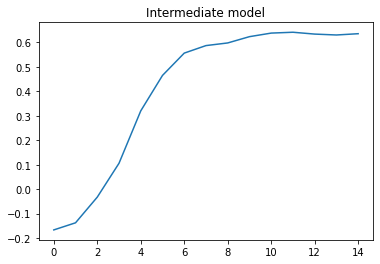

Epoch 1/15
----------
train Loss:  2.5035 Acc:  0.5776 lr:  1.0000e-04
val Loss:  2.1236 Acc:  0.6341 lr:  1.0000e-04

Epoch 2/15
----------
train Loss:  2.5427 Acc:  0.5756 lr:  1.0000e-04
val Loss:  2.1604 Acc:  0.6292 lr:  1.0000e-04

Epoch 3/15
----------
train Loss:  2.5074 Acc:  0.5768 lr:  1.0000e-04
val Loss:  2.1818 Acc:  0.6265 lr:  1.0000e-04

Epoch 4/15
----------
train Loss:  2.5622 Acc:  0.5698 lr:  1.0000e-04
val Loss:  2.1964 Acc:  0.6246 lr:  1.0000e-04

Epoch 5/15
----------
train Loss:  2.4960 Acc:  0.5781 lr:  1.0000e-04
val Loss:  2.1895 Acc:  0.6256 lr:  1.0000e-04

Epoch 6/15
----------
train Loss:  2.5164 Acc:  0.5749 lr:  1.0000e-04
val Loss:  2.1891 Acc:  0.6261 lr:  1.0000e-04

Epoch 7/15
----------
train Loss:  2.6341 Acc:  0.5556 lr:  1.0000e-04
val Loss:  2.1809 Acc:  0.6275 lr:  1.0000e-04

Epoch 8/15
----------
train Loss:  2.4967 Acc:  0.5786 lr:  1.0000e-04
val Loss:  2.1760 Acc:  0.6281 lr:  1.0000e-04

Epoch 9/15
----------
train Loss:  2.4398 Acc:  

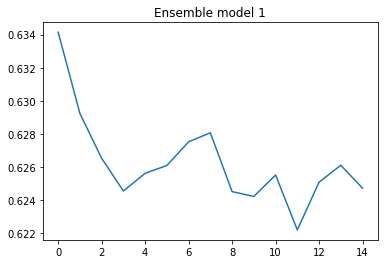

Epoch 1/15
----------
train Loss:  6.5152 Acc: -0.0164 lr:  7.2296e-03
val Loss:  7.8483 Acc: -0.2573 lr:  7.2296e-03

Epoch 2/15
----------
train Loss:  4.2606 Acc:  0.3113 lr:  7.2296e-03
val Loss:  10.3525 Acc: -0.8217 lr:  7.2296e-03

Epoch 3/15
----------
train Loss:  3.6232 Acc:  0.4152 lr:  7.2296e-03
val Loss:  7.9504 Acc: -0.4456 lr:  7.2296e-03

Epoch 4/15
----------
train Loss:  3.1486 Acc:  0.4882 lr:  7.2296e-03
val Loss:  5.8546 Acc: -0.0301 lr:  7.2296e-03

Epoch 5/15
----------
train Loss:  3.1475 Acc:  0.4923 lr:  7.2296e-03
val Loss:  4.0528 Acc:  0.3053 lr:  7.2296e-03

Epoch 6/15
----------
train Loss:  2.8007 Acc:  0.5477 lr:  7.2296e-03
val Loss:  3.1818 Acc:  0.4558 lr:  7.2296e-03

Epoch 7/15
----------
train Loss:  2.6332 Acc:  0.5693 lr:  7.2296e-03
val Loss:  2.6947 Acc:  0.5423 lr:  7.2296e-03

Epoch 8/15
----------
train Loss:  2.5445 Acc:  0.5888 lr:  7.2296e-03
val Loss:  2.4066 Acc:  0.5876 lr:  7.2296e-03

Epoch 9/15
----------
train Loss:  2.6085 Acc: 

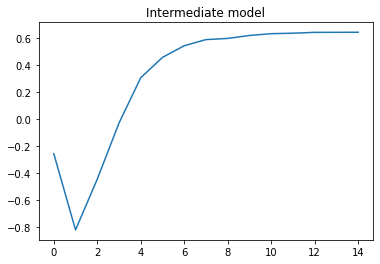

Epoch 1/15
----------
train Loss:  2.4732 Acc:  0.5821 lr:  1.0000e-04
val Loss:  2.1445 Acc:  0.6301 lr:  1.0000e-04

Epoch 2/15
----------
train Loss:  2.4048 Acc:  0.5897 lr:  1.0000e-04
val Loss:  2.1625 Acc:  0.6288 lr:  1.0000e-04

Epoch 3/15
----------
train Loss:  2.3380 Acc:  0.6048 lr:  1.0000e-04
val Loss:  2.1755 Acc:  0.6271 lr:  1.0000e-04

Epoch 4/15
----------
train Loss:  2.3613 Acc:  0.6058 lr:  1.0000e-04
val Loss:  2.1801 Acc:  0.6266 lr:  1.0000e-04

Epoch 5/15
----------
train Loss:  2.2876 Acc:  0.6124 lr:  1.0000e-04
val Loss:  2.1813 Acc:  0.6264 lr:  1.0000e-04

Epoch 6/15
----------
train Loss:  2.4189 Acc:  0.5905 lr:  1.0000e-04
val Loss:  2.1879 Acc:  0.6259 lr:  1.0000e-04

Epoch 7/15
----------
train Loss:  2.3316 Acc:  0.6066 lr:  1.0000e-04
val Loss:  2.1700 Acc:  0.6284 lr:  1.0000e-04

Epoch 8/15
----------
train Loss:  2.4404 Acc:  0.5887 lr:  1.0000e-04
val Loss:  2.1785 Acc:  0.6272 lr:  1.0000e-04

Epoch 9/15
----------
train Loss:  2.3771 Acc:  

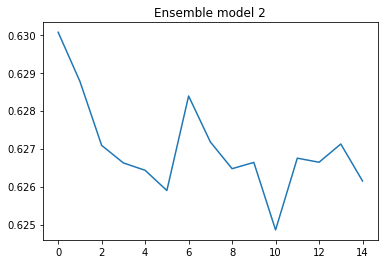

In [104]:
for e in range(1, n_ensemble + 1):
       
    # Intermediate model
    model = models.resnet50(pretrained=True)
    set_parameter_requires_grad(model, feature_extract_im)
    num_ftrs = model.fc.in_features
    new_layers = get_output_layers(dropout, num_ftrs, n_dim, n_layers)
    model.fc = new_layers # last fully connected layer
    
    # Send the model to GPU
    model = model.to(device)
    
    # create datalaoders with specific batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size_im)
    val_loader = DataLoader(val_dataset, batch_size=batch_size_im)
    dataloaders_dict = {"train":train_loader,"val":val_loader}
    
    # Create Optimizer and define params to update
    params_to_update = model.parameters()
    if feature_extract_im:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                #print("\t",name)

    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                #print("\t",name)
                ...


    # Instantiate optimizer for intermediate model
    optimizer = optim.Adam(params_to_update, lr = lr_im)
    
    # Setup the loss fxn
    criterion = get_criterion('L2')
    
    # Initial training and evaluate
    model, hist, lrs = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs_im)
    
    # Plot learning curve
    plt.plot(hist)
    plt.title('Intermediate model')
    plt.show()
    
    # Save intermediate model
    torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, PATH_IM)

    # fine tuning
    
    # create datalaoders with specific batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size_ft)
    val_loader = DataLoader(val_dataset, batch_size=batch_size_ft)
    dataloaders_dict = {"train":train_loader,"val":val_loader}
            
    # Create Optimizer and define params to update
    params_to_update = model.parameters()
    if feature_extract_ft:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                #print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                #print("\t",name)
                ...

    # Instantiate optimizer for finetuning
    optimizer = optim.SGD(params_to_update, lr = lr_ft, momentum = 0.9)
    
    # Setup the loss fxn
    criterion = get_criterion("L2")

    # Train and evaluate fine tuned model
    model, hist, lrs = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs_ft)
    
    # Plot learning curve
    plt.plot(hist)
    plt.title(f'Ensemble model {e}')
    plt.show()
    
    # Save intermediate model
    PATH_EN = f'CNN_checkpoints/state_dict_ensemble_model_{e}.pt'
    torch.save(model.state_dict(), PATH_EN)

## Load checkpoints and get predictions for validation and test sets

In [66]:
def load_pretrained_model(e):

    # Load intermediate model for finetuning
    model = models.resnet50(pretrained=True)
    set_parameter_requires_grad(model, feature_extract_ft)
    num_ftrs = model.fc.in_features
    new_layers = get_output_layers(dropout, num_ftrs, n_dim, n_layers)
    model.fc = new_layers # last fully connected layer

    # OPTIONAL: Load pre-trained state
    checkpoint = torch.load(CHECKPOINTS + f'state_dict_ensemble_model_{e+1}.pt')
    model.load_state_dict(checkpoint)

    # Send the model to GPU
    return model.to(device)


def predict(model, data_loader, unlabeled=False):
    """Computes predictions for a given mnodel and dataset"""
    
    model.eval()

    outputs = list()
    since = time.time()
    with torch.no_grad():
        if unlabeled:
            for inputs in data_loader:
                inputs = inputs.to(device)
                output = model(inputs)
                outputs.append(output.squeeze().numpy())
        else:
            for inputs, _ in data_loader:
                inputs = inputs.to(device)
                output = model(inputs)
                outputs.append(output.squeeze().numpy())

    return np.array(outputs)

### Create dataloaders for inference

In [58]:
pred_loader = DataLoader(pred_dataset, batch_size=1, shuffle=False, num_workers=0)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

### Run ensemble model

In [72]:
validate_pred = []
test_pred = []
rocks_120_pred = []

for e in range(n_ensemble):
    model = load_pretrained_model(e)
    validate_pred.append(predict(model, train_loader))
    test_pred.append(predict(model, test_loader))
    rocks_120_pred.append(predict(model, pred_loader, unlabeled=True))
    
validate_pred = np.array(validate_pred)
test_pred = np.array(test_pred)
rocks_120_pred = np.array(rocks_120_pred)

# compute mean of all ensemble models
validate_prediction = np.mean(validate_pred, 0)
test_prediction = np.mean(test_pred, 0)
rocks_120_prediction = np.mean(rocks_120_pred, 0)

### Save predictions to file

In [79]:
cnn_pred_file = "CNN Predictions/MDS Dimensions/cnn_torch_predicted_mds_120.txt"

np.savetxt(cnn_pred_file, rocks_120_prediction)